## 0. EDA och filhantering

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

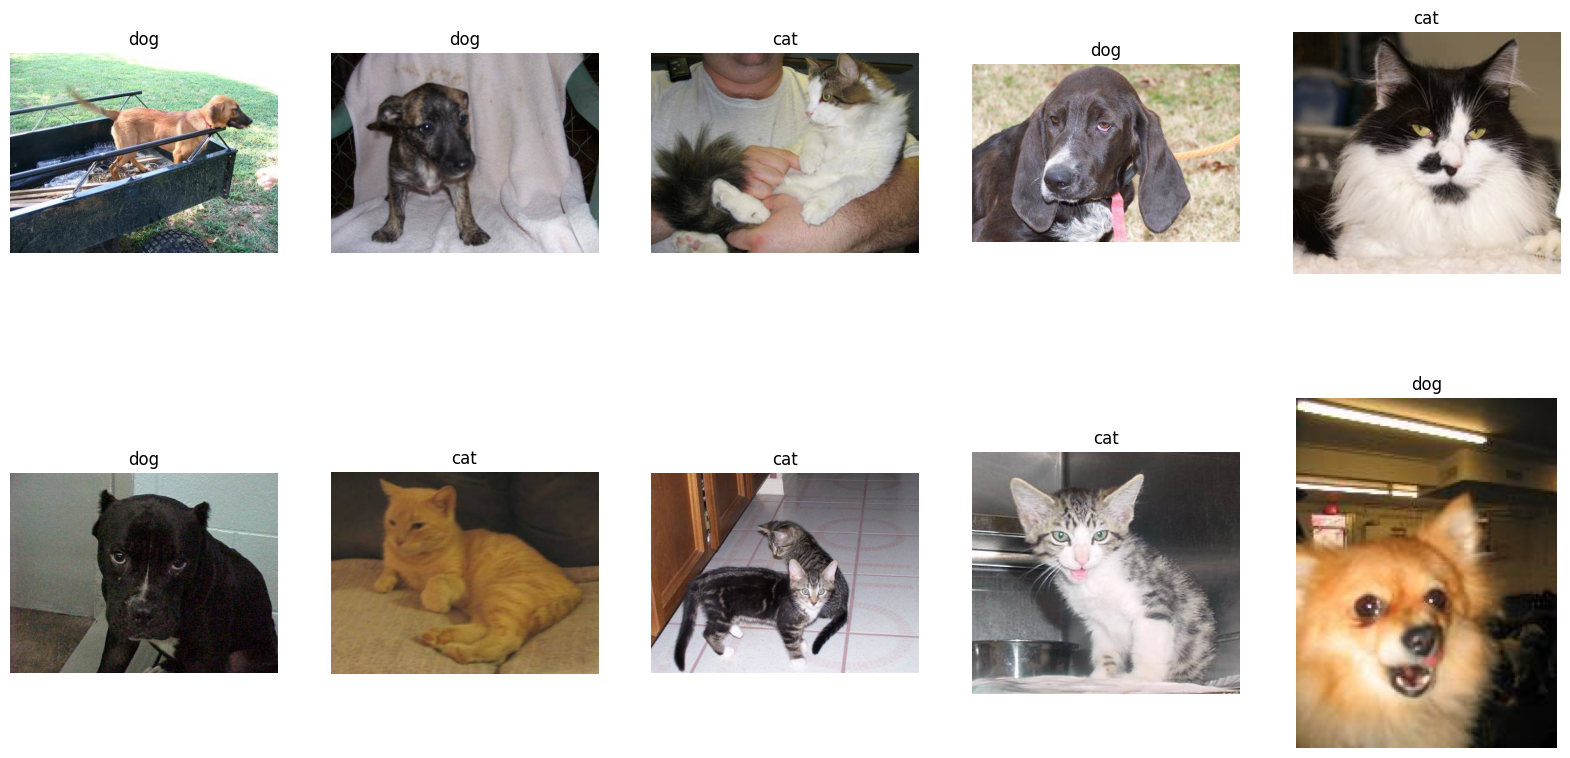

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from pathlib import Path
import os


# din lokala miljö
local_path = Path("experiment_small_data/original_data/train/train")

# Kontrollera om koden körs på Kaggle
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    data_path = Path("/kaggle/input/cats-and-dogs/experiment_small_data/original_data/train/train")
else:
    data_path = local_path

# Hämta alla bildsökvägar
all_images = list(data_path.glob("*.jpg"))

# Välj 10 slumpmässiga bilder
selected_images = np.random.choice(all_images, 10, replace=False)

# Plotta bilder och deras labels
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = "dog" if "dog" in image_path.stem else "cat"
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

In [ ]:

# Skapa varje mapp separat istället för att sammanslå dem i en sträng
folders = [
    'experiment_small_data/test/cats', 'experiment_small_data/test/dogs', 
    'experiment_small_data/train/cats', 'experiment_small_data/train/dogs', 
    'experiment_small_data/val/cats', 'experiment_small_data/val/dogs', 
    'original_data/test/test', 'original_data/train/train'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

### train|val|test split

In [3]:
import shutil

# Funktion för att dela upp och kopiera bilder
def distribute_images(source_folder, target_folder, num_train, num_val, num_test):
    dogs = list(source_folder.glob("*dog*.jpg"))
    cats = list(source_folder.glob("*cat*.jpg"))
    np.random.shuffle(dogs)
    np.random.shuffle(cats)

    # Definierar splits
    train_dogs, val_dogs, test_dogs = dogs[:800], dogs[800:1000], dogs[1000:1250]
    train_cats, val_cats, test_cats = cats[:800], cats[800:1000], cats[1000:1250]

    # Funktion för att kopiera filer
    def copy_files(files, path):
        for file in files:
            shutil.copy(file, path)

    # Skapa nya mappar om de inte redan finns
    os.makedirs(target_folder / 'train/dogs', exist_ok=True)
    os.makedirs(target_folder / 'val/dogs', exist_ok=True)
    os.makedirs(target_folder / 'test/dogs', exist_ok=True)
    os.makedirs(target_folder / 'train/cats', exist_ok=True)
    os.makedirs(target_folder / 'val/cats', exist_ok=True)
    os.makedirs(target_folder / 'test/cats', exist_ok=True)

    # Kopiera filer
    copy_files(train_dogs, target_folder / 'train/dogs')
    copy_files(val_dogs, target_folder / 'val/dogs')
    copy_files(test_dogs, target_folder / 'test/dogs')
    copy_files(train_cats, target_folder / 'train/cats')
    copy_files(val_cats, target_folder / 'val/cats')
    copy_files(test_cats, target_folder / 'test/cats')

# Anger käll- och målmappar baserat på om koden körs på Kaggle eller lokalt
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    source_folder = Path("/kaggle/input/cats-and-dogs/original_data/train/train")
    target_folder = Path("/kaggle/input/cats-and-dogs/experiment_small_data")
else:
    source_folder = Path("original_data/train/train")
    target_folder = Path("experiment_small_data")

# Distribuera bilder
distribute_images(source_folder, target_folder, 1600, 400, 500)

#### e) Läs in dataseten från experiment_small och plocka ut labelsvektorer, som
#### ska vara one-hot encoded med 0 och 1.

In [4]:
from tensorflow.keras.utils import to_categorical


def load_data(directory):
    # Definiera kategorier och initiera listor för bilder och labels
    categories = ['dogs', 'cats']
    images = []
    labels = []

    # Läs in bilder och deras labels
    for category in categories:
        category_path = Path(directory) / category
        class_num = categories.index(category)
        for img_path in category_path.iterdir():
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(class_num)

    # Konvertera till numpy arrays och one-hot encode labels
    images = np.array(images)
    labels = to_categorical(labels, num_classes=2)
    return images, labels

#  Kaggle eller lokalt
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    base_directory = Path("/kaggle/input/cats-and-dogs/experiment_small_data")
else:
    base_directory = Path("experiment_small_data")

# Läser in data från källan
train_images, train_labels = load_data(base_directory / 'train')
val_images, val_labels = load_data(base_directory / 'val')
test_images, test_labels = load_data(base_directory / 'test')

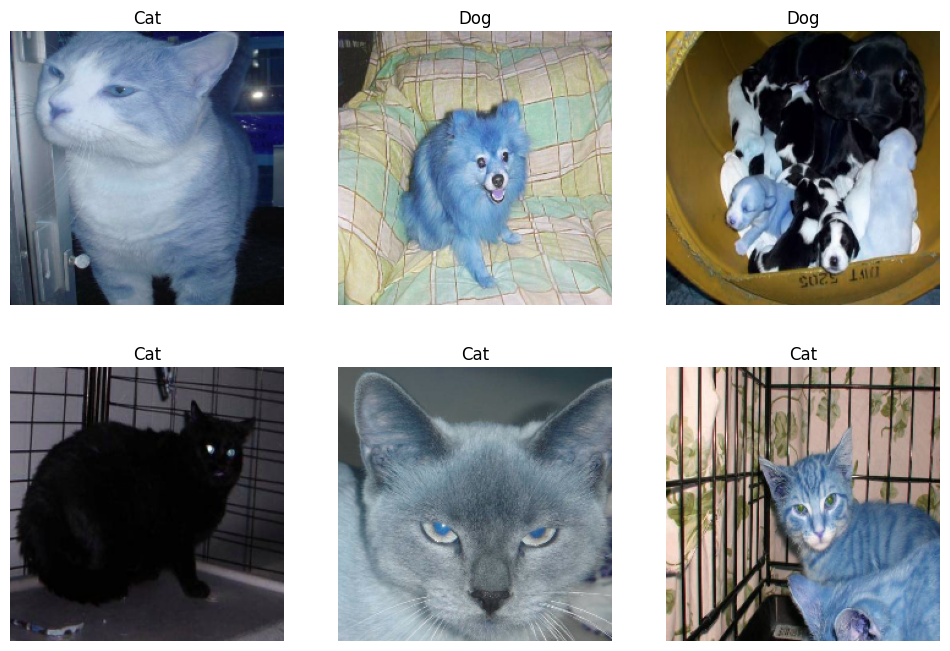

In [5]:

def plot_random_images_with_labels(images, labels):
    plt.figure(figsize=(12, 8))
    indices = np.random.choice(len(images), 6, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx])
        plt.title('Dog' if np.argmax(labels[idx]) == 0 else 'Cat')
        plt.axis('off')
    plt.show()

# Plotta slumpmässiga bilder med labels för att kontrollera korrekthet
plot_random_images_with_labels(test_images, test_labels)

In [ ]:

def plot_class_distribution(labels):
    # Beräkna antalet instanser av varje klass
    counts = np.sum(labels, axis=0)
    plt.bar(['Dogs', 'Cats'], counts)
    plt.title('Class Distribution')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

# Plotta klassfördelningen för train set
plot_class_distribution(train_labels)

In [ ]:
def plot_shuffle_check(labels, title="Shuffle Check"):
    # Konvertera one-hot encoded labels till enkel klassindikation
    indices = np.argmax(labels, axis=1)
    
    plt.figure(figsize=(10, 3))
    plt.plot(indices, marker='o', linestyle='', markersize=2)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Class Index')
    plt.yticks([0, 1], ['Dogs', 'Cats'])  # Antag att 0 är Dogs och 1 är Cats
    plt.show()

# Använd denna funktion för att plotta shuffle check för train, validation, och test datasets
plot_shuffle_check(train_labels, title="Train Data Shuffle Check")
plot_shuffle_check(val_labels, title="Validation Data Shuffle Check")
plot_shuffle_check(test_labels, title="Test Data Shuffle Check")

## Bildbehandling

Unique sizes found: 1
All images are the same size: [224, 224]


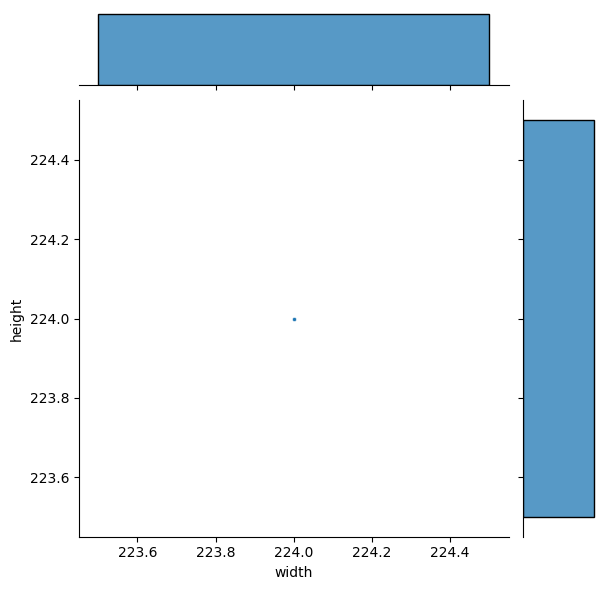

In [6]:
import pandas as pd

#  träningsdata beroende på miljö
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    base_directory = Path("/kaggle/input/cats-and-dogs/experiment_small_data/train")
else:
    base_directory = Path("experiment_small_data/train")

train_dogs_path = base_directory / 'dogs'
train_cats_path = base_directory / 'cats'

# Samlar alla bildsökvägar
train_images = list(train_dogs_path.glob("*.jpg")) + list(train_cats_path.glob("*.jpg"))

# Samlar bildstorlekar, med felhantering om en bild inte kan läsas
sizes = []
for image in train_images:
    img = cv2.imread(str(image))
    if img is not None:
        sizes.append((img.shape[0], img.shape[1]))
    else:
        print(f"Warning: Could not read image {image}")

# Skapa en DataFrame för att enklare hantera data
df_sizes = pd.DataFrame(sizes, columns=["height", "width"])

# Kontrollera unika storlekar
unique_sizes = df_sizes.drop_duplicates()
print(f"Unique sizes found: {len(unique_sizes)}")
if len(unique_sizes) == 1:
    print(f"All images are the same size: {unique_sizes.iloc[0].to_list()}")

# Plottar relationen mellan höjd och bredd på bilderna, med inställningar för att hantera tät data
sns.jointplot(data=df_sizes, x="width", y="height", kind="scatter", marker='.')
plt.show()

#### 1b Välj en lämplig bildstorlek

In [7]:
# För att ändra storlek på bilderna
def resize_images(image_paths, size=(224, 224)):
    for image_path in image_paths:
        img = cv2.imread(str(image_path))
        img_resized = cv2.resize(img, size)
        cv2.imwrite(str(image_path), img_resized)

resize_images(train_images)  # Uppdaterar alla träningsbilder till den nya storleken

#### 1c Spara bilder i numpy arrays

In [ ]:
def load_images_to_array(image_paths, size=(224, 224)):
    images = np.array([cv2.resize(cv2.imread(str(image_path)), size) for image_path in image_paths])
    return images

# Ladda om bilderna och spara dem som en numpy array
train_images_array = load_images_to_array(train_images)

print(train_images_array.shape)

#### 1d Augmentera datan

Dataaugmentering är viktigt för att öka modellens generaliserbarhet och förhindra överanpassning, särskilt när vi har en begränsad mängd data. Augmentering kan inkludera rotationer, skalning, horisontell flipping, och färgvariationer.

Parametrarna för dataaugmentering väljs med hänsyn till typen av data, det specifika problemet som ska lösas och mängden tillgänglig data. Genom att överväga naturen av datan, typen av problem, tillgänglig mängd data och önskad inverkan kan man välja lämpliga parametrar. Det innebär att man kan experimentera med olika parametrar och utvärdera resultatet för att finjustera dataaugmenteringen för att uppnå bästa möjliga prestanda.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definiera en ImageDataGenerator för data augmentering
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualisera några augmenterade bilder
augmented_images = next(data_gen.flow(train_images_array, batch_size=10))

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i].astype('uint8'))
    plt.axis('off')
plt.show()

#### 2. Träna modeller

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_model(num_filters, dropout_rate):
    # Skapa en sekventiell modell
    model = Sequential([
        # Första konvolutionella lagret med ReLU-aktivering
        Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        # Första MaxPooling-lagret för att minska storleken på bilderna
        MaxPooling2D(2, 2),
        # Andra konvolutionella lagret, med dubbla antalet filter
        Conv2D(num_filters * 2, (3, 3), activation='relu'),
        # Andra MaxPooling-lagret för ytterligare storleksreduktion
        MaxPooling2D(2, 2),
        # Plattar ut datan för att kunna ansluta den till tätt anslutna lager
        Flatten(),
        # Fullt anslutet lager med 512 noder
        Dense(512, activation='relu'),
        # Dropout-lager för att minska risken för överanpassning
        Dropout(dropout_rate),
        # Output-lagret med en enda nod, använder sigmoid för binär klassificering
        Dense(1, activation='sigmoid')
    ])
    
    # Returnera den färdigbyggda modellen
    return model


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# basmappar för data beroende på körningsmiljön
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    base_path = Path("/kaggle/input/cats-and-dogs/experiment_small_data")
else:
    base_path = Path("experiment_small_data")

train_path = base_path / 'train'
val_path = base_path / 'val'
test_path = base_path / 'test'

# Skapar en bildgenerator för träningsdata med skalning av pixelvärdena
train_datagen = ImageDataGenerator(rescale=1./255)
# Använder bildgeneratorn för att läsa in bilder från träningsmappen
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=20, class_mode='binary')

# Skapar en bildgenerator för valideringsdata, med samma skalning
val_datagen = ImageDataGenerator(rescale=1./255)
# Använder bildgeneratorn för att läsa in bilder från valideringsmappen
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=20, class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
# Skapar en ny CNN-modell med 32 filter i det första lagret och en dropout-rate på 50%
model_no_aug = create_model(32, 0.5)

# Kompilerar modellen med Adam-optimizer, används för att uppdatera nätverkets vikter baserat på träningsdatan
model_no_aug.compile(
    optimizer='adam',  # Optimeringsalgoritm, effektiv för stora datamängder och parametrar
    loss='binary_crossentropy',  # Förlustfunktion som är lämplig för binär klassificering
    metrics=['accuracy']  # accuracy används för att bedöma modellens prestanda under träning och validering
)

# Tränar modellen med data från train_generator, och använder val_generator för valideringsdata
history_no_aug = model_no_aug.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator  # Data som används för att validera modellens prestanda per epoch
)


In [ ]:
# Skapar en ImageDataGenerator med flera dataaugmenteringsparametrar för träning
aug_train_datagen = ImageDataGenerator(
    rescale=1./255,  # Skalar om pixelvärdena till [0,1]
    rotation_range=40,  # Bilder roteras slumpmässigt inom detta intervall
    width_shift_range=0.2,  # Horisontella förskjutningar 
    height_shift_range=0.2,  # Vertikala förskjutningar 
    shear_range=0.2,  # Skjuvning av bilden
    zoom_range=0.2,  # Zooma in/ut bilder
    horizontal_flip=True  # Slumpmässigt spegelvända bilder horisontellt
)

# Använder datageneratorn för att läsa in bilder från träningsmappen
aug_train_generator = aug_train_datagen.flow_from_directory(
    train_path,  
    target_size=(224, 224),  
    batch_size=20, 
    class_mode='binary'  
)

model_aug = create_model(32, 0.5)

# Kompilerar modellen med Adam-optimizer och binär korsentropi som förlustfunktion
model_aug.compile(
    optimizer='adam',  # Optimeringsalgoritm
    loss='binary_crossentropy',  # Förlustfunktion för binär klassificering
    metrics=['accuracy']  # spårar tränings- och valideringsnoggrannhet
)

# Tränar modellen med augmenterade träningsdata och använder valgeneratorn för validering
history_aug = model_aug.fit(
    aug_train_generator,  # Augmenterad träningsdatagenerator
    epochs=10,
    validation_data=val_generator  # Data som används för att validera modellens prestanda per epoch
)


In [ ]:
# Visualiserar loss-kurvorna
plt.plot(history_no_aug.history['loss'], label='T Loss (No Aug)')
plt.plot(history_no_aug.history['val_loss'], label='Val Loss (No Aug)')
plt.plot(history_aug.history['loss'], label='T Loss (With Aug)')
plt.plot(history_aug.history['val_loss'], label='Val Loss (With Aug)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualiserar accuracy-kurvorna
plt.plot(history_no_aug.history['accuracy'], label='T Acc (No Aug)')
plt.plot(history_no_aug.history['val_accuracy'], label='Val Acc (No Aug)')
plt.plot(history_aug.history['accuracy'], label='T Acc (With Aug)')
plt.plot(history_aug.history['val_accuracy'], label='Val Acc (With Aug)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### Uppgift 2b: Förändra

Genom att lägga till en extra Convolutional layer ökar modellens komplexitet och förmåga att extrahera abstrakta och komplexa mönster från bilderna. Detta kan vara särskilt användbart när datan innehåller många olika detaljer och mönster som modellen behöver lära sig att skilja mellan.

In [4]:
def modified_model(num_filters, dropout_rate):
    model = Sequential([
        Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(num_filters * 2, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(num_filters * 4, (3, 3), activation='relu'),  # Extra Convolutional layer
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

# Tränar den modifierade modellen
mod_model = modified_model(32, 0.5)
mod_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mod_history = mod_model.fit(aug_train_generator, epochs=10, validation_data=val_generator)

NameError: name 'Sequential' is not defined

In [ ]:
# Evaluerar modellen på valideringsdatan
val_loss, val_acc = mod_model.evaluate(val_generator)
print("Validation Accuracy: ", val_acc)


### Uppgift 2c: Välj en Modell och Gör Inferens

In [ ]:
# Skapar en ImageDataGenerator för testdata, med omnormering av pixelvärdena till intervallet [0,1]
test_datagen = ImageDataGenerator(rescale=1./255)

# Skapar en data generator för testmappen, med specificerad bildstorlek och batchstorlek utan att blanda datan
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=20, 
    class_mode='binary',
    shuffle=False  # Data blandas inte, vilket är viktigt för testning för att behålla ordning på label och prediktion
)

# den modifierade modellen används
test_loss, test_acc = mod_model.evaluate(test_generator)  # Utvärderar modellen på testdatan

print("Test Accuracy: ", test_acc)


Det är uppmuntrande att se att testnoggrannheten är liknande eller till och med lite högre än valideringsnoggrannheten. Detta tyder på att modellen generaliserar väl till osedd data och inte visar tecken på overfitting.

### Uppgift 2d: Transfer Learning
